In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/skincareapp/acne clean pigmentation wrinkles/acne_267.jpg
/kaggle/input/skincareapp/acne clean pigmentation wrinkles/attractive_087.jpg
/kaggle/input/skincareapp/acne clean pigmentation wrinkles/pigmentation_0470.jpg
/kaggle/input/skincareapp/acne clean pigmentation wrinkles/acne_684.jpg
/kaggle/input/skincareapp/acne clean pigmentation wrinkles/wrinkle_430.jpg
/kaggle/input/skincareapp/acne clean pigmentation wrinkles/pigmentation_0236.jpg
/kaggle/input/skincareapp/acne clean pigmentation wrinkles/acne_683.jpg
/kaggle/input/skincareapp/acne clean pigmentation wrinkles/attractive_323.jpg
/kaggle/input/skincareapp/acne clean pigmentation wrinkles/wrinkle_414.jpg
/kaggle/input/skincareapp/acne clean pigmentation wrinkles/attractive_873.jpg
/kaggle/input/skincareapp/acne clean pigmentation wrinkles/attractive_2057.jpg
/kaggle/input/skincareapp/acne clean pigmentation wrinkles/acne_769.jpg
/kaggle/input/skincareapp/acne clean pigmentation wrinkles/pigmentation_0209.jpg
/kaggl

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import os, random
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, Model
from tensorflow.keras.applications import EfficientNetV2S

!pip install -q keras-tuner

import keras_tuner as kt

print("TensorFlow Version:", tf.__version__)
print("Keras Tuner Version:", kt.__version__)

2025-12-24 12:40:45.264479: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1766580045.724855      47 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1766580045.865641      47 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

TensorFlow Version: 2.18.0
Keras Tuner Version: 1.4.7


In [2]:
def set_seeds(seed=42):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

set_seeds()

#Configuration
IMG_SIZE = (224, 224)
BATCH_SIZE = 32  # You can try 16 if you get OOM errors
CLASSES = ["acne", "pigmentation", "wrinkles"]

#PATHS
OUTPUT_DIR = "/kaggle/working/"

#Auto-detect the dataset path in Kaggle
DATA_ROOT = ""
for dirname, _, filenames in os.walk('/kaggle/input'):
    if "labels.csv" in filenames:
        DATA_ROOT = dirname
        break

if not DATA_ROOT:
    print("WARNING: Could not find dataset automatically. Please set DATA_ROOT manually.")
else:
    print(f"Dataset found at: {DATA_ROOT}")
    print(f"Saving models to: {OUTPUT_DIR}")

#Load CSV
df = pd.read_csv(os.path.join(DATA_ROOT, "labels.csv"))
df["filename"] = df["filename"].apply(lambda x: os.path.join(DATA_ROOT, x))

Dataset found at: /kaggle/input/skincareapp/acne clean pigmentation wrinkles
Saving models to: /kaggle/working/


In [7]:
train_val_df, test_df = train_test_split(
    df,
    test_size=0.15,
    random_state=42,
    stratify=df[CLASSES]
)

train_df, val_df = train_test_split(
    train_val_df,
    test_size=0.15,
    random_state=42,
    stratify=train_val_df[CLASSES]
)

#Class counts for weighted loss
pos_counts = train_df[CLASSES].sum().values.astype("float32")
neg_counts = (len(train_df) - pos_counts).astype("float32")

print("Train size:", len(train_df), "| Val size:", len(val_df), "| Test size:", len(test_df))
print("Pos counts:", pos_counts, "| Neg counts:", neg_counts)


Train size: 3656 | Val size: 646 | Test size: 760
Pos counts: [1015.  386.  738.] | Neg counts: [2641. 3270. 2918.]


In [8]:
# ==============================================================================
# CELL 4: Create tf.data Pipelines (Updated for EfficientNetV2-S)
# ==============================================================================

# --- Optional: Data Augmentation Layer ---
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.05),
    layers.RandomZoom(0.1),
], name="data_augmentation")


def parse_function(filename, labels):
    image_string = tf.io.read_file(filename)
    image_decoded = tf.io.decode_jpeg(image_string, channels=3)

    # EfficientNetV2 expects float32 in [0,1]
    image = tf.image.convert_image_dtype(image_decoded, tf.float32)

    # Resize to model input size (384x384) via IMG_SIZE
    image_resized = tf.image.resize(image, IMG_SIZE)

    return image_resized, labels


def create_dataset(df, batch_size, augment=False):
    dataset = tf.data.Dataset.from_tensor_slices(
        (df["filename"].values, df[CLASSES].values.astype(np.float32))
    )

    dataset = dataset.map(parse_function, num_parallel_calls=tf.data.AUTOTUNE)

    # Apply augmentation only on training data
    if augment:
        dataset = dataset.map(
            lambda x, y: (data_augmentation(x, training=True), y),
            num_parallel_calls=tf.data.AUTOTUNE
        )

    dataset = dataset.cache()
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset


# Create datasets
train_ds = create_dataset(train_df, BATCH_SIZE, augment=True)
val_ds   = create_dataset(val_df,   BATCH_SIZE, augment=False)
test_ds  = create_dataset(test_df,  BATCH_SIZE, augment=False)


In [9]:
# ==============================================================================
# CELL 5: EfficientNetV2-S Model with Keras Tuner
# ==============================================================================

import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.applications import EfficientNetV2S
import keras_tuner as kt

def build_efficientnetv2s_model(hp):
    """
    Build EfficientNetV2-S model with hyperparameter tuning.
    Keeps your weighted BCE loss + metrics.
    """

    # ------------------------------
    # Hyperparameters
    # ------------------------------
    learning_rate = hp.Choice("learning_rate", [1e-4, 5e-5, 1e-5])
    dropout_rate = hp.Choice("dropout_rate", [0.2, 0.3, 0.4])
    hidden_units = hp.Int("hidden_units", min_value=256, max_value=768, step=128)

    # ------------------------------
    # Base Model (Pretrained)
    # ------------------------------
    base_model = EfficientNetV2S(
        include_top=False,
        include_preprocessing=True,  # automatically normalizes input
        weights="imagenet",
        input_shape=IMG_SIZE + (3,)
    )

    # Full fine-tuning
    base_model.trainable = True

    inputs = layers.Input(shape=IMG_SIZE + (3,))
    x = base_model(inputs, training=True)

    # ------------------------------
    # Classification Head
    # ------------------------------
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(dropout_rate)(x)
    x = layers.Dense(hidden_units, activation="gelu")(x)
    x = layers.Dropout(dropout_rate)(x)

    outputs = layers.Dense(len(CLASSES), activation="sigmoid")(x)
    model = Model(inputs, outputs, name="EfficientNetV2S_MultiLabel")

    # ------------------------------
    # Weighted Binary Cross-Entropy
    # ------------------------------
    pos_counts_tf = tf.constant(pos_counts, dtype=tf.float32)
    neg_counts_tf = tf.constant(neg_counts, dtype=tf.float32)

    pos_weight = neg_counts_tf / (pos_counts_tf + 1e-6)
    neg_weight = tf.ones_like(pos_weight)

    def weighted_bce(y_true, y_pred, smooth=0.05, eps=1e-7):
        # Label smoothing
        y_true = y_true * (1.0 - smooth) + 0.5 * smooth

        # Numerical stability
        y_pred = tf.clip_by_value(y_pred, eps, 1.0 - eps)

        w_pos_batch = pos_weight[tf.newaxis, :]
        w_neg_batch = neg_weight[tf.newaxis, :]

        loss_pos = - w_pos_batch * y_true * tf.math.log(y_pred)
        loss_neg = - w_neg_batch * (1.0 - y_true) * tf.math.log(1.0 - y_pred)

        return tf.reduce_mean(loss_pos + loss_neg)

    # ------------------------------
    # Compile Model
    # ------------------------------
    model.compile(
        optimizer=tf.keras.optimizers.AdamW(learning_rate=learning_rate),
        loss=weighted_bce,
        metrics=[
            tf.keras.metrics.BinaryAccuracy(name="acc", threshold=0.5),
            tf.keras.metrics.AUC(name="auc", multi_label=True),
            tf.keras.metrics.Precision(name="precision"),
            tf.keras.metrics.Recall(name="recall"),
        ],
    )

    return model

print("✅ EfficientNetV2-S model builder is ready!")


✅ EfficientNetV2-S model builder is ready!


In [10]:
# ==============================================================================
# CELL 6: Hyperparameter Tuning (Save to Working Dir)
# ==============================================================================
import tensorflow as tf
import keras_tuner as kt
import os
import gc

# Clear memory before starting
tf.keras.backend.clear_session()
gc.collect()

def build_tuner():
    tuner = kt.RandomSearch(
        build_efficientnetv2s_model,
        objective=kt.Objective("val_auc", direction="max"),
        max_trials=5,
        executions_per_trial=1,
        # CRITICAL CHANGE: Save to writable directory
        directory=os.path.join(OUTPUT_DIR, "keras_tuner_efficientnetv2s"),
        project_name="efficientnetv2s_skin_tuning"
    )
    return tuner

tuner = build_tuner()

# Callbacks
tuning_callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor="val_auc", mode="max", patience=3, restore_best_weights=True)
]

print("🚀 Starting EfficientNetV2-S Hyperparameter Tuning...")
tuner.search(
    train_ds, # Or train_ds_small if you defined it
    validation_data=val_ds, # Or val_ds_small
    epochs=15,
    callbacks=tuning_callbacks,
    verbose=1
)

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"✅ Best Learning Rate: {best_hps.get('learning_rate')}")

Trial 5 Complete [00h 10m 48s]
val_auc: 0.9912443161010742

Best val_auc So Far: 0.9978646636009216
Total elapsed time: 00h 48m 14s
✅ Best Learning Rate: 5e-05


In [11]:
# ==============================================================================
# CELL 7: Train Final Model (Save to Working Dir)
# ==============================================================================

print("\n🏗️ Building final model...")
best_model = tuner.hypermodel.build(best_hps)

# CRITICAL CHANGE: Save to writable directory
EFFNETV2S_FINAL_PATH = os.path.join(OUTPUT_DIR, "efficientnetv2s_tuned_best.keras")

final_callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor="val_auc", mode="max", patience=10, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor="val_auc", mode="max", factor=0.5, patience=5, min_lr=1e-7),
    tf.keras.callbacks.ModelCheckpoint(EFFNETV2S_FINAL_PATH, monitor="val_auc", mode="max", save_best_only=True)
]

print("🎯 Training final EfficientNetV2-S...")
history_final = best_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    callbacks=final_callbacks,
    verbose=1
)
print(f"💾 Model saved to: {EFFNETV2S_FINAL_PATH}")


🏗️ Building final model...
🎯 Training final EfficientNetV2-S...
Epoch 1/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 275s 1s/step - acc: 0.7507 - auc: 0.8626 - loss: 0.8816 - precision: 0.4337 - recall: 0.8293 - val_acc: 0.9334 - val_auc: 0.9825 - val_loss: 0.5023 - val_precision: 0.7536 - val_recall: 0.9788 - learning_rate: 5.0000e-05
Epoch 2/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 42s 362ms/step - acc: 0.9653 - auc: 0.9949 - loss: 0.4448 - precision: 0.8586 - recall: 0.9828 - val_acc: 0.9727 - val_auc: 0.9876 - val_loss: 0.4438 - val_precision: 0.8935 - val_recall: 0.9762 - learning_rate: 5.0000e-05
Epoch 3/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 38s 327ms/step - acc: 0.9891 - auc: 0.9996 - loss: 0.3843 - precision: 0.9482 - recall: 0.9984 - val_acc: 0.9876 - val_auc: 0.9876 - val_loss: 0.4040 - val_precision: 0.9492 - val_recall: 0.9894 - learning_rate: 5.0000e-05
Epoch 4/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 41s 353ms/step - acc: 0.9959 - auc: 1.0000 - loss: 0.3686 - precision: 0.9815 - recall: 0.9976 - val_acc: 0.

In [14]:
# ==============================================================================
# CELL 8: EfficientNetV2-S + SE (Squeeze-and-Excitation) Block
# ==============================================================================
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.applications import EfficientNetV2S

# --- 1. Define Squeeze-and-Excitation (SE) Block ---
def se_block(x, ratio=16):
    """
    Squeeze-and-Excitation Block.
    Explicitly models channel interdependencies.
    """
    filters = x.shape[-1]
    # Squeeze: Global Average Pooling
    se = layers.GlobalAveragePooling2D()(x)
    
    # Excitation: Two Fully Connected (Dense) layers
    se = layers.Dense(filters // ratio, activation="relu")(se)
    se = layers.Dense(filters, activation="sigmoid")(se)
    
    # Rescale: Multiply input by the importance scores
    se = layers.Reshape((1, 1, filters))(se)
    return layers.multiply([x, se])

# --- 2. Build the Model ---
def build_efficientnetv2s_se():
    print("🏗️ Building EfficientNetV2-S + SE variant...")
    
    # Base Model (Pre-trained)
    base_model = EfficientNetV2S(
        include_top=False,
        include_preprocessing=True,
        weights="imagenet",
        input_shape=IMG_SIZE + (3,)
    )
    base_model.trainable = True # Full fine-tuning

    inputs = layers.Input(shape=IMG_SIZE + (3,))
    x = base_model(inputs, training=True)

    # --- Add SE Block here ---
    # We apply attention to the high-level features from the backbone
    x = se_block(x)

    # Classification Head
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(512, activation="gelu")(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(len(CLASSES), activation="sigmoid")(x)

    model = Model(inputs, outputs, name="EfficientNetV2S_SE")
    
    # Use the weighted BCE loss defined in previous cells
    # (If 'pos_counts' isn't available from Cell 4, standard binary_crossentropy is used as backup)
    try:
        # Re-defining weighted loss just in case context was lost
        pos_counts_tf = tf.constant(pos_counts, dtype=tf.float32)
        neg_counts_tf = tf.constant(neg_counts, dtype=tf.float32)
        pos_weight = neg_counts_tf / (pos_counts_tf + 1e-6)
        neg_weight = tf.ones_like(pos_weight)

        def weighted_bce(y_true, y_pred, smooth=0.05, eps=1e-7):
            y_true = y_true * (1.0 - smooth) + 0.5 * smooth
            y_pred = tf.clip_by_value(y_pred, eps, 1.0 - eps)
            w_pos_batch = pos_weight[tf.newaxis, :]
            w_neg_batch = neg_weight[tf.newaxis, :]
            loss_pos = - w_pos_batch * y_true * tf.math.log(y_pred)
            loss_neg = - w_neg_batch * (1.0 - y_true) * tf.math.log(1.0 - y_pred)
            return tf.reduce_mean(loss_pos + loss_neg)
            
        loss_fn = weighted_bce
        print("✅ Using Weighted Binary Cross Entropy Loss")
    except:
        loss_fn = "binary_crossentropy"
        print("⚠️ 'pos_counts' not found. Defaulting to standard binary_crossentropy.")

    model.compile(
        optimizer=tf.keras.optimizers.AdamW(learning_rate=1e-4),
        loss=loss_fn,
        metrics=[
            tf.keras.metrics.BinaryAccuracy(name="acc", threshold=0.5),
            tf.keras.metrics.AUC(name="auc", multi_label=True),
            tf.keras.metrics.Precision(name="precision"),
            tf.keras.metrics.Recall(name="recall"),
        ],
    )
    return model

# Initialize the model
model_se = build_efficientnetv2s_se()
model_se.summary()

🏗️ Building EfficientNetV2-S + SE variant...
✅ Using Weighted Binary Cross Entropy Loss


Model: "EfficientNetV2S_SE"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_9       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ efficientnetv2-s    │ (None, 7, 7,      │ 20,331,360 │ input_layer_9[0]… │
│ (Functional)        │ 1280)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 1280)      │          0 │ efficientnetv2-s… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_12 (Dense)    │ (None, 80)        │    102,480 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_13 (Dense)    │ (None, 1280)      │    103,680 │ dense_12[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_2 (Reshape) │ (None, 1, 1,      │          0 │ dense_13[0][0]    │
│                     │ 1280)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_2          │ (None, 7, 7,      │          0 │ efficientnetv2-s… │
│ (Multiply)          │ 1280)             │            │ reshape_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 1280)      │          0 │ multiply_2[0][0]  │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_8 (Dropout) │ (None, 1280)      │          0 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_14 (Dense)    │ (None, 512)       │    655,872 │ dropout_8[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_9 (Dropout) │ (None, 512)       │          0 │ dense_14[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_15 (Dense)    │ (None, 3)         │      1,539 │ dropout_9[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 21,194,931 (80.85 MB)

 Trainable params: 21,041,059 (80.27 MB)

 Non-trainable params: 153,872 (601.06 KB)

In [15]:
# ==============================================================================
# CELL 9: Train SE Model
# ==============================================================================
import time

# Define Save Path for Kaggle (Writable directory)
SE_MODEL_PATH = os.path.join(OUTPUT_DIR, "efficientnetv2s_se_best.keras")

# Callbacks
callbacks_se = [
    tf.keras.callbacks.EarlyStopping(monitor="val_auc", mode="max", patience=8, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor="val_auc", mode="max", factor=0.2, patience=3, min_lr=1e-7),
    # Save best model to writable dir
    tf.keras.callbacks.ModelCheckpoint(SE_MODEL_PATH, monitor="val_auc", mode="max", save_best_only=True)
]

print("\n🚀 Starting Training for EfficientNetV2-S + SE...")
start_time = time.time()

history_se = model_se.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30, # Adjustable
    callbacks=callbacks_se,
    verbose=1
)

train_time = (time.time() - start_time) / 60.0
print(f"\n✅ Training Complete in {train_time:.1f} minutes.")
print(f"💾 Best SE model saved to: {SE_MODEL_PATH}")


🚀 Starting Training for EfficientNetV2-S + SE...
Epoch 1/30
115/115 ━━━━━━━━━━━━━━━━━━━━ 275s 1s/step - acc: 0.7660 - auc: 0.8984 - loss: 0.8177 - precision: 0.4698 - recall: 0.8823 - val_acc: 0.9530 - val_auc: 0.9911 - val_loss: 0.4720 - val_precision: 0.8210 - val_recall: 0.9709 - learning_rate: 1.0000e-04
Epoch 2/30
115/115 ━━━━━━━━━━━━━━━━━━━━ 42s 364ms/step - acc: 0.9828 - auc: 0.9988 - loss: 0.3965 - precision: 0.9236 - recall: 0.9934 - val_acc: 0.9871 - val_auc: 0.9979 - val_loss: 0.3972 - val_precision: 0.9491 - val_recall: 0.9868 - learning_rate: 1.0000e-04
Epoch 3/30
115/115 ━━━━━━━━━━━━━━━━━━━━ 38s 328ms/step - acc: 0.9944 - auc: 0.9999 - loss: 0.3654 - precision: 0.9741 - recall: 0.9978 - val_acc: 0.9907 - val_auc: 0.9972 - val_loss: 0.3891 - val_precision: 0.9663 - val_recall: 0.9868 - learning_rate: 1.0000e-04
Epoch 4/30
115/115 ━━━━━━━━━━━━━━━━━━━━ 38s 333ms/step - acc: 0.9986 - auc: 1.0000 - loss: 0.3560 - precision: 0.9928 - recall: 1.0000 - val_acc: 0.9902 - val_auc:


📊 Evaluating SE Model on Test Set...
   Generating predictions...
24/24 ━━━━━━━━━━━━━━━━━━━━ 25s 650ms/step


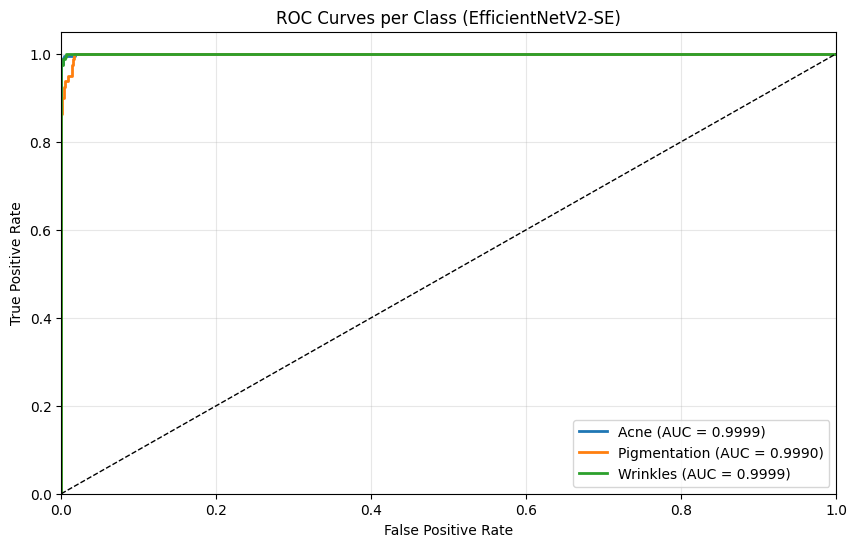

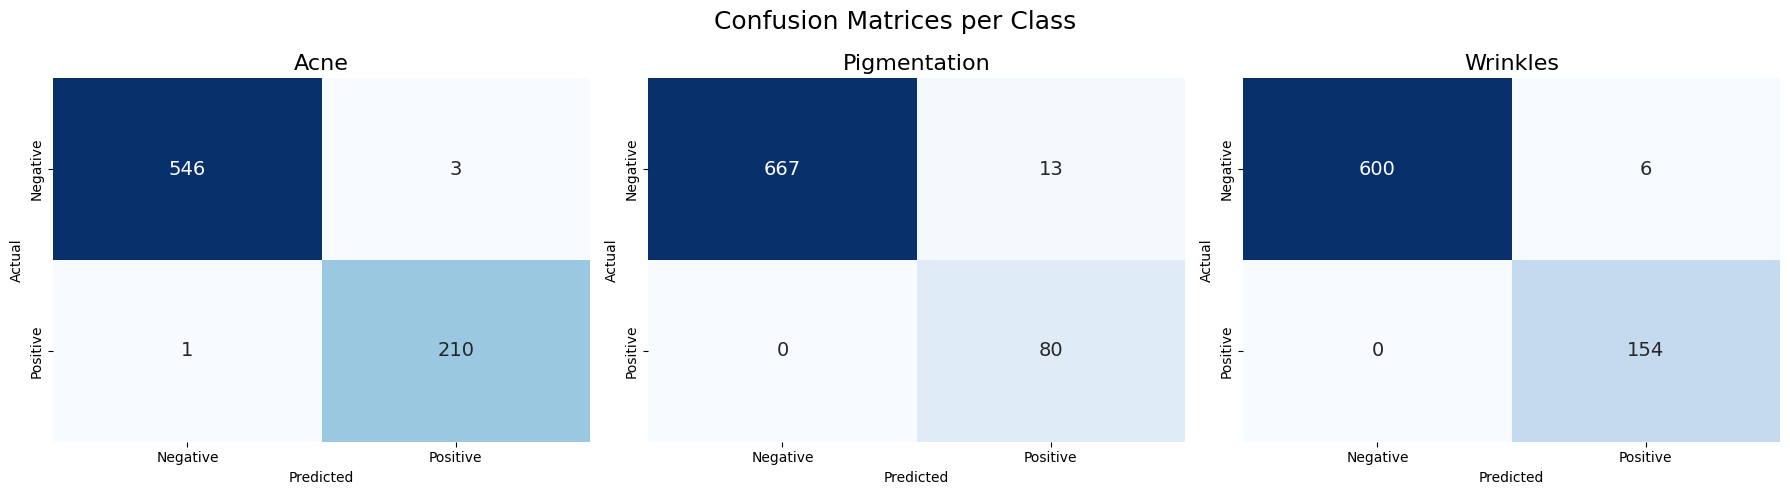

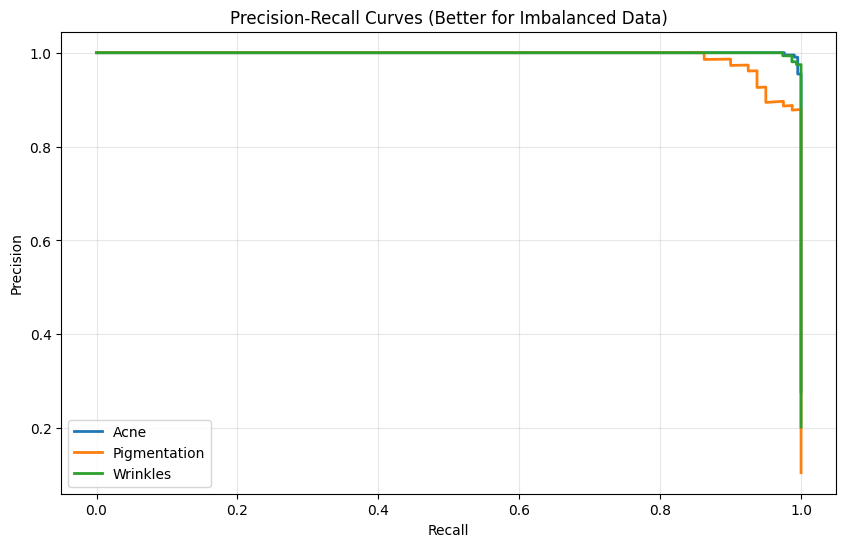


🏆 FINAL RESULTS REPORT
🔹 ACNE:
   AUC:       0.9999
   Accuracy:  0.9947
   Precision: 0.9859
   Recall:    0.9953
--------------------
🔹 PIGMENTATION:
   AUC:       0.9990
   Accuracy:  0.9829
   Precision: 0.8602
   Recall:    1.0000
--------------------
🔹 WRINKLES:
   AUC:       0.9999
   Accuracy:  0.9921
   Precision: 0.9625
   Recall:    1.0000
--------------------
✅ All plots saved to /kaggle/working/.


In [16]:
# ==============================================================================
# CELL 10: Evaluation & Professional Visualization
# ==============================================================================
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             roc_auc_score, confusion_matrix, roc_curve, precision_recall_curve)
import os

# Ensure Output Directory Exists
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

print("\n📊 Evaluating SE Model on Test Set...")

# 1. Get Predictions
print("   Generating predictions...")
y_pred_proba = model_se.predict(test_ds, verbose=1)
y_true = np.concatenate([y for x, y in test_ds], axis=0)

# Save for Ensemble
np.save(os.path.join(OUTPUT_DIR, "effnet_se_preds.npy"), y_pred_proba)
np.save(os.path.join(OUTPUT_DIR, "test_true_labels.npy"), y_true)

# Convert to Binary (Threshold 0.5)
y_pred_binary = (y_pred_proba > 0.5).astype(int)

# --- PLOT 1: ROC CURVES (All Classes) ---
plt.figure(figsize=(10, 6))
colors = ['#1f77b4', '#ff7f0e', '#2ca02c'] # Blue, Orange, Green

for i, class_name in enumerate(CLASSES):
    fpr, tpr, _ = roc_curve(y_true[:, i], y_pred_proba[:, i])
    auc_score = roc_auc_score(y_true[:, i], y_pred_proba[:, i])
    plt.plot(fpr, tpr, label=f'{class_name.capitalize()} (AUC = {auc_score:.4f})', color=colors[i], linewidth=2)

plt.plot([0, 1], [0, 1], 'k--', lw=1) # Random guess line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves per Class (EfficientNetV2-SE)')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.savefig(os.path.join(OUTPUT_DIR, "roc_curves.png"), dpi=300)
plt.show()

# --- PLOT 2: CONFUSION MATRICES (Side-by-Side) ---
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for i, class_name in enumerate(CLASSES):
    cm = confusion_matrix(y_true[:, i], y_pred_binary[:, i])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i], cbar=False, annot_kws={"size": 14})
    axes[i].set_title(f'{class_name.capitalize()}', fontsize=16)
    axes[i].set_xlabel('Predicted')
    axes[i].set_ylabel('Actual')
    axes[i].set_xticklabels(['Negative', 'Positive'])
    axes[i].set_yticklabels(['Negative', 'Positive'])

plt.suptitle('Confusion Matrices per Class', fontsize=18)
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "confusion_matrices.png"), dpi=300)
plt.show()

# --- PLOT 3: PRECISION-RECALL CURVES ---
plt.figure(figsize=(10, 6))

for i, class_name in enumerate(CLASSES):
    precision, recall, _ = precision_recall_curve(y_true[:, i], y_pred_proba[:, i])
    plt.plot(recall, precision, label=f'{class_name.capitalize()}', color=colors[i], linewidth=2)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves (Better for Imbalanced Data)')
plt.legend()
plt.grid(alpha=0.3)
plt.savefig(os.path.join(OUTPUT_DIR, "pr_curves.png"), dpi=300)
plt.show()

# --- TEXT REPORT ---
print("\n" + "="*40)
print("🏆 FINAL RESULTS REPORT")
print("="*40)

for i, class_name in enumerate(CLASSES):
    auc = roc_auc_score(y_true[:, i], y_pred_proba[:, i])
    acc = accuracy_score(y_true[:, i], y_pred_binary[:, i])
    prec = precision_score(y_true[:, i], y_pred_binary[:, i], zero_division=0)
    rec = recall_score(y_true[:, i], y_pred_binary[:, i], zero_division=0)
    
    print(f"🔹 {class_name.upper()}:")
    print(f"   AUC:       {auc:.4f}")
    print(f"   Accuracy:  {acc:.4f}")
    print(f"   Precision: {prec:.4f}")
    print(f"   Recall:    {rec:.4f}")
    print("-" * 20)

print(f"✅ All plots saved to {OUTPUT_DIR}.")